In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
images=np.load("/Users/arjunmalik/Documents/CAPSTONE/brain_tumor_dataset/images.npy",allow_pickle=True)
labels=np.load("/Users/arjunmalik/Documents/CAPSTONE/brain_tumor_dataset/labels.npy",allow_pickle=True)
masks=np.load("/Users/arjunmalik/Documents/CAPSTONE/brain_tumor_dataset/masks.npy",allow_pickle=True)

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


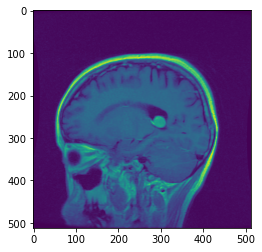

1


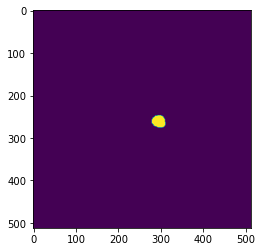

In [3]:
# plotting a sample
imgplot = plt.imshow(images[0])
plt.show()
print(labels[0])
imgplot=plt.imshow(masks[0])
plt.show()

In [4]:
data=np.column_stack((images,masks,labels))
data.shape

(3064, 3)

How the data is distributed between 3 classes

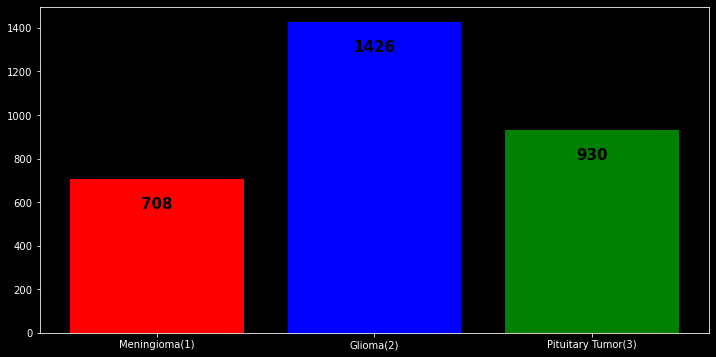

In [5]:
plt.style.use("dark_background")

labels, counts = np.unique(data[:,2], return_counts=True)

plt.figure(figsize=(12,6))
plt.bar(labels, counts, color=["red", "blue", "green"],
        tick_label=['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'])


for row, value in zip(labels,counts):
    plt.annotate(int(value), xy=(row, value-150), 
                rotation=0, color="black", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")

# Splitting data in training, testing and validation 

In [6]:
from sklearn.model_selection import train_test_split
train_data, val_data=train_test_split(data,test_size=0.1,random_state=42)
train_data, test_data=train_test_split(data,test_size=0.2,random_state=42)

print("Train:", train_data.shape, "\nVal:", val_data.shape, "\nTest:", test_data.shape)

Train: (2451, 3) 
Val: (307, 3) 
Test: (613, 3)


Examples of images of each class

In [7]:
import cv2

def data_to_viz(data, label, n=5):
    
   
    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]
    
    
    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]
    
    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:
        
     
        imgs.append(cv2.resize(data_i[0], (512, 512)))

       
        masks.append(cv2.resize(data_i[1].astype("uint8"), 
                                (512, 512)))

     
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

In [8]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


PLOT

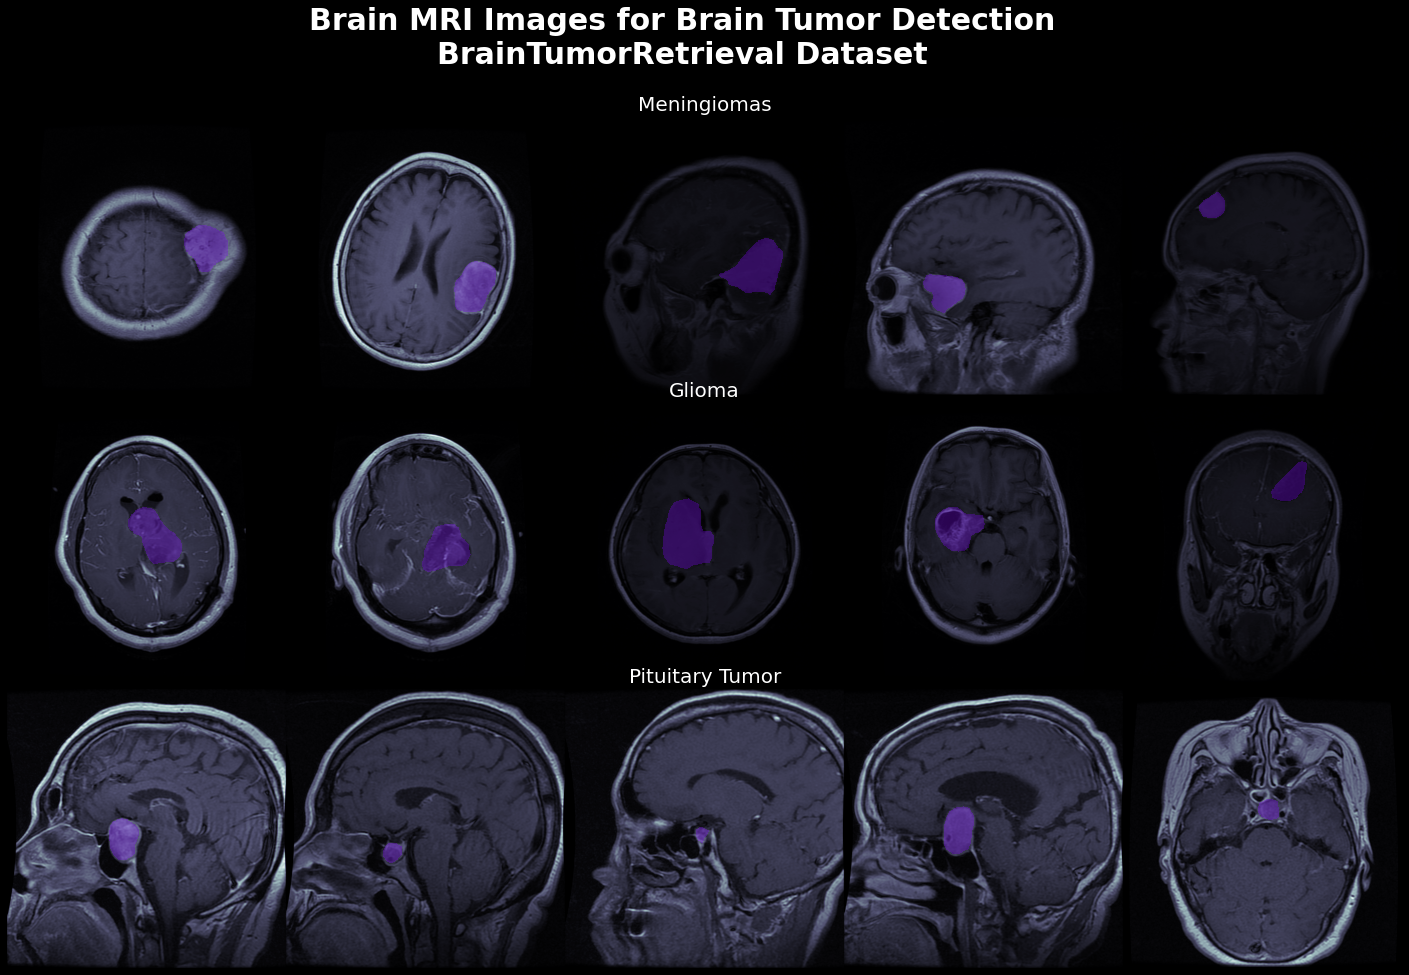

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False, 
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()


Segmentation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):
        
        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        image = self.data[idx][0].astype("float32")

        # global standardization of pixels
        mean, std = image.mean(), image.std()
        image = (image - mean) / std
        
        # convert to rgb
        image_rgb = np.stack([image]*3).transpose(1,2,0)
        
        # create target masks
        label = self.data[idx][2] -1
        mask = np.expand_dims(self.data[idx][1], -1)
        
        target_mask = np.zeros((mask.shape[0], mask.shape[1], 
                                self.n_classes))
        target_mask[:,:, label : label + 1] = mask.astype("uint8")
        
        #  binary mask
        target_mask = np.clip(target_mask, 0, 1).astype("float32")
        
        # augmentations
        augmented = self.transforms(image=image_rgb, 
                                    mask=target_mask)
        image = augmented['image']
        mask = augmented['mask']
        
        return image, mask

Data Transformations

In [12]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, 
                       border_mode=0),
                        
    A.GridDistortion(p=0.5),
    A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    A.Resize(156, 156, p=1.),
    A.RandomCrop(128, 128, p=1.)
    ])

Data Generation

In [13]:
# train
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, 
                              shuffle=True)

# validation
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4, 
                            shuffle=True)

# test
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4, 
                             shuffle=True)

In [ ]:
def show_aug(inputs, nrows=3, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 15:
        inputs = inputs[:15]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy()#.transpose(1,2,0)
            #mean = [0.485, 0.456, 0.406]
            #std = [0.229, 0.224, 0.225] 
            #img = (img*std+mean).astype(np.float32)
            #img = np.clip(img, 0,1)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)), img.mean())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks)

# UNet

In [18]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [19]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

LOSS and Metric


In [21]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_coef_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore